In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F

# Set device to GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Allow augmentation transform for training set, no augementation for val/test set

train_preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

eval_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=eval_preprocess)

# DataLoaders for the three datasets

BATCH_SIZE=128
NUM_WORKERS=4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

100%|██████████| 170498071/170498071 [00:12<00:00, 13216599.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of two convolutions each: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1
    Total layers: 1+32+1 = 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 8, 36, 3] sets of three convolutions each: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1
    Total layers: 1+150+1 = 152
    '''
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model: train a model on a dataset

            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # print('outputs', outputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [7]:
resnet = ResNet18().to(device)
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)

best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 25, 'resnet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.8278 Acc: 0.3359
Epoch time taken:  38.82344317436218
val Loss: 1.6096 Acc: 0.4126
Epoch time taken:  41.56334352493286

Epoch 1/24
----------
train Loss: 1.3345 Acc: 0.5096
Epoch time taken:  32.58383655548096
val Loss: 1.2214 Acc: 0.5575
Epoch time taken:  35.319592237472534

Epoch 2/24
----------
train Loss: 1.0359 Acc: 0.6286
Epoch time taken:  33.18031167984009
val Loss: 1.0460 Acc: 0.6333
Epoch time taken:  35.95146894454956

Epoch 3/24
----------
train Loss: 0.8468 Acc: 0.7003
Epoch time taken:  33.7601432800293
val Loss: 0.8474 Acc: 0.7018
Epoch time taken:  36.57734560966492

Epoch 4/24
----------
train Loss: 0.6917 Acc: 0.7561
Epoch time taken:  34.186075925827026
val Loss: 0.7898 Acc: 0.7311
Epoch time taken:  37.02428841590881

Epoch 5/24
----------
train Loss: 0.5792 Acc: 0.7968
Epoch time taken:  34.37534213066101
val Loss: 0.6990 Acc: 0.7661
Epoch time taken:  37.24114775657654

Epoch 6/24
----------
train Loss: 0.4835 Acc: 0.8306
Epoc

In [8]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [9]:
class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

In [10]:
ressenet = ResSENet18().to(device)
# Optimizer, loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
optimizer2 = optim.Adam(params_to_update2, lr=0.01)

best_model2, val_acc_history2, loss_acc_history2 = train_model(ressenet, dataloaders, criterion2, optimizer2, 25, 'ressenet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.6609 Acc: 0.3871
Epoch time taken:  37.09454154968262
val Loss: 1.4567 Acc: 0.4750
Epoch time taken:  40.1116406917572

Epoch 1/24
----------
train Loss: 1.1697 Acc: 0.5797
Epoch time taken:  36.65005087852478
val Loss: 1.0190 Acc: 0.6422
Epoch time taken:  39.6251163482666

Epoch 2/24
----------
train Loss: 0.9076 Acc: 0.6763
Epoch time taken:  36.62747001647949
val Loss: 0.8278 Acc: 0.7125
Epoch time taken:  39.639283418655396

Epoch 3/24
----------
train Loss: 0.7339 Acc: 0.7393
Epoch time taken:  36.61910605430603
val Loss: 0.7274 Acc: 0.7441
Epoch time taken:  39.601197242736816

Epoch 4/24
----------
train Loss: 0.6059 Acc: 0.7863
Epoch time taken:  36.65056538581848
val Loss: 0.7076 Acc: 0.7590
Epoch time taken:  39.65566396713257

Epoch 5/24
----------
train Loss: 0.5064 Acc: 0.8236
Epoch time taken:  36.62407565116882
val Loss: 0.5934 Acc: 0.7946
Epoch time taken:  39.57992959022522

Epoch 6/24
----------
train Loss: 0.4293 Acc: 0.8493
Epoch

In [23]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'ResNet18')
    plt.plot(loss_acc_history2, label = 'ResSENet18')
    plt.title('Training loss over time')
    plt.legend()
    plt.show()

    val_acc_history_cpu = [x.cpu().detech() for x in val_acc_history]
    val_acc_history_cpu2 = [x.cpu().detech() for x in val_acc_history2]
    plt.plot(val_acc_history, label = 'ResNet18')
    plt.plot(val_acc_history2, label = 'ResSENet18')
    plt.title('Validation accuracy over time')
    plt.legend()
    plt.show()

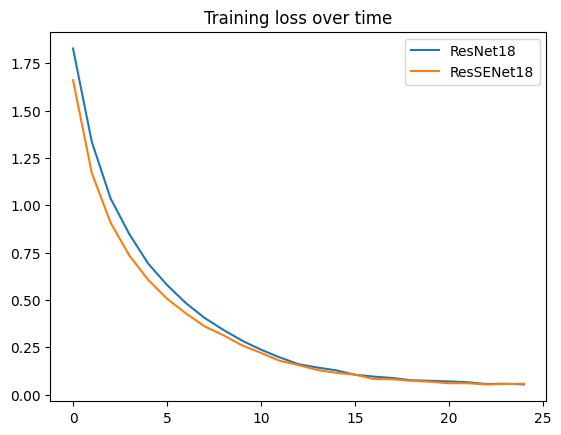

AttributeError: ignored

In [24]:
plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2)